In [6]:
%matplotlib inline

import numpy as np

import time
import math
from numpy.linalg import inv
from numpy.linalg import det
import matplotlib
from scipy.stats import binom
#from scipy.stats import gamma
from scipy.stats import laplace
from scipy.optimize import minimize
from scipy import integrate
from scipy.optimize import minimize
from scipy.misc import derivative
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import gamma 
from scipy.special import psi
from scipy.stats import dirichlet
from scipy.stats import wishart
from scipy.misc import logsumexp

from matplotlib.patches import Ellipse

<h2> Ejemplo de Variational Linear Regression </h2>

Para ser totalmente no solo se debe integrar sobre los parámetros sino también sobre los hiperparámetros. La integración analítica es intratable, sin embargo utilizando métodos variacionales se puede encontrar una aproximación. Supondremos el parámetro $\beta$ como conocido. A continuación se escriben las diferentes distribuciones y ecuaciones del método (sacadas de Pattern Recognition and Machine Learning de Bishop, y desarrolladas en mayor detalle). \\

La primera ecuación corresponde a la likelihood para w, y la segunda el prior para w.

 \begin{eqnarray}
    p(\boldsymbol{t}|w) &=& \prod\limits_{n=1}^{N} \mathcal{N}( t_n | {\boldsymbol{w}}^T {\phi}_n, {\beta}^{-1})
 \end{eqnarray}

 \begin{eqnarray}
    p(\boldsymbol{w}|\alpha) &=&  \mathcal{N}(\boldsymbol{w}|\boldsymbol{0}, {\alpha}^{-1} \boldsymbol{I})
 \end{eqnarray}
 
 \\
 
 El prior conjugado de la precisión de una gausiana es dado por la distribución gamma:
 
  \begin{eqnarray}
    p(\alpha) &=&  Gam(\alpha | a_0, b_0)
 \end{eqnarray}
 
 Siendo finalmente la distribución conjunta: 
 
   \begin{eqnarray}
    p(\boldsymbol{t},w,\alpha) &=&  p(\boldsymbol{t}|w)p(\boldsymbol{w}|\alpha)p(\alpha)
 \end{eqnarray}
 
 <h2> Variational Distribution </h2>
 
 Dado el modelo gráfico propuesto en la literatura, la distribución posterior variacional que da la forma:
 
   \begin{eqnarray}
    q(\boldsymbol{w},\alpha) &=&  q(\boldsymbol{w})q(\alpha)
 \end{eqnarray}
 
 Teniendo este resultado podemos calcular para cada factor, el logaritmo sobre todas las variables y promediar respecto a las variable no presentes en el factor. Primero se analiza la distribución sobre \alpha . Dejando solamente no términos que dependen de \alpha se obtiene lo siguiente. (derivación detallada).
 
\begin{eqnarray}
 \ln {q^{*}}(\alpha) &=& \ln p(\alpha) + \mathbb{E}_{\boldsymbol{w}}[\ln p(\boldsymbol{w}|\alpha)] + const
 \end{eqnarray}
 
 El primer término es el logaritmo de una distribución Gamma definida anteriormente, queda de la siguiente forma al aplicar logaritmo:
 
 \begin{eqnarray}
 \ln p(\alpha) &=& \ln Gam(\alpha | a_0, b_0) \\
               &=& \ln { \frac{{b_0}^{a_0}}{\Gamma(a_0)} {\alpha}^{a_0-1} e^{-b_0 \alpha} } \\
               &=& (a_0 - 1) \ln{\alpha} -b_0 \alpha + \ln{\frac{{b_0}^{a_0}}{\Gamma(a_0)}}
 \end{eqnarray}
 El último elemento es constante respecto a alpha por lo que se suma a la constante. \\
 
 Ahora analizamos el segundo elemento de la ecuación. Para ello recordamos que un prior gaussiano puede ser generalizado de la siguiente manera (ecuación 3.56 de Bishop).
 
 \begin{eqnarray}
 p(\boldsymbol{w}|\alpha) &=& \Bigg[ \frac{q}{2}(\frac{\alpha}{2})^{1/q} \frac{1}{\Gamma(1/q)} \Bigg] exp \Bigg(  - \frac{\alpha}{2} \sum\limits_{j=1}^{M}{|w_j|}^q  \Bigg)
 \end{eqnarray}
 
 Con el parámetro $ q = 2 $ se tiene una distribución gaussiana. Quedando:
 
  \begin{eqnarray}
 p(\boldsymbol{w}|\alpha) &=& \Bigg[ (\frac{\alpha}{2})^{1/2} \frac{1}{\Gamma(1/2)} \Bigg] exp \Bigg(  - \frac{\alpha}{2} \sum\limits_{j=1}^{M}{|w_j|}^2  \Bigg)
 \end{eqnarray}
 
 Al aplicar logaritmo y calcular la esperana sobre w nos quedarán los factores:
 
 \begin{eqnarray}
 \frac{M}{2} \ln{\alpha} - \frac{\alpha}{2} \mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}] + const
 \end{eqnarray}
 
 Luego, sumando los resultados anterior obtenemos:
 
 \begin{eqnarray}
 \ln {q^{*}}(\alpha) &=& (a_0 - 1) \ln{\alpha} -b_0 \alpha \frac{M}{2} \ln{\alpha} - \frac{\alpha}{2} \mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}] + const
 \end{eqnarray}
 
 Se observa que se trata de una distribución log gamma, calculando la exponencial de la misma obtenemos una distribución Gamma. Se juntan los factores que están multiplicados por $\ln{\alpha}$, y aquellos multiplicados por $\alpha$ para obtener lo siguiente:
 
 \begin{eqnarray}
 exp (\ln {q^{*}}(\alpha)) &=& exp((a_0 - 1) \ln{\alpha} -b_0 \alpha \frac{M}{2} \ln{\alpha} - \frac{\alpha}{2} \mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}] + const ) \\            
         &=& exp( (a_0 + \frac{M}{2} - 1) \alpha + \ln{\alpha} (-b_0 - (1/2)\mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}] )  ) + const \\
         &=& {\alpha}^{a_0 + \frac{M}{2} - 1} exp(-(b_0 + (1/2)\mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}]))
 \end{eqnarray}
 
 Le agregamos un factor constante respecto a $\alpha$:
 \begin{eqnarray}
 exp (\ln {q^{*}}(\alpha)) &=& \frac{{(b_0 + \frac{1}{2}\mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}] )}^{a_0 + \frac{M}{2}}}{\Gamma(a_0 + \frac{M}{2})} {\alpha}^{a_0 + \frac{M}{2} - 1} exp(-(b_0 + \mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}]))
 \end{eqnarray}
 
 Con esto determinamos que:
 
  \begin{eqnarray}
q^{*}(\alpha) &=& Gam(\alpha | a_N, b_N)
 \end{eqnarray}
 
 donde
 
 \begin{eqnarray}
a_N &=& a_0 + \frac{M}{2}
 \end{eqnarray}
 
 \begin{eqnarray}
b_N &=& b_0 + \frac{1}{2} \mathbb{E}[{\boldsymbol{w}}^T {\boldsymbol{w}}]
 \end{eqnarray}
 
 De manera similar podemos obtener reestimación variacional de la posterior sobre $w$. Dejando solo los términos dependientes de $w$ se tiene que:
 
 \begin{eqnarray}
\ln q^{*}(w) &=& \ln p(\boldsymbol{t}|w) + {\mathbb{E}}_{\alpha}[ \ln p(w|\alpha)] + const
 \end{eqnarray}
 
 Nuevamente, dividimos el desarrollo de la ecuación en dos partes. Primero calculamos el primer término, dado las ecuaciones anteriores tenemos lo siguiente:
  
 \begin{eqnarray}
\ln p(\boldsymbol{t}|w) &=& \ln (\prod\limits_{n=1}^{N} \mathcal{N}( t_n | {\boldsymbol{w}}^T {\phi}_n, {\beta}^{-1}) ) \\
                        &=& \sum\limits_{n=1}^{N} -\frac{\beta}{2}(t_n \boldsymbol{w}^T \phi_n)^2 + const
 \end{eqnarray}
El factor sin el exponencial dentro de la distribución gaussiana es enviado a la constante (dado que no depende de t).

Desarrollando la segunda parte de la ecuación tenemos:

\begin{eqnarray}
 {\mathbb{E}}_{\alpha}[ \ln p(w|\alpha)] &=& {\mathbb{E}}_{\alpha}[ \ln \mathcal{N}(\boldsymbol{w}|\boldsymbol{0}, {\alpha}^{-1} \boldsymbol{I})]
     &=& {\mathbb{E}}_{\alpha}[ - \frac{1}{2} \alpha \sum\limits_{m=1}^{M} (w_m)^2  ] \\
     &=& - \frac{1}{2} {\mathbb{E}}_{\alpha} \boldsymbol{w} \boldsymbol{w}^T
 \end{eqnarray}


Sumando los resultados anteriores obtenemos: 
 \begin{eqnarray}
     \ln q^{*}(w) &=& -\frac{\beta}{2}\sum\limits_{n=1}^{N} (t_n \boldsymbol{w}^T \phi_n)^2 - \frac{1}{2} {\mathbb{E}}_{\alpha}[\alpha] \boldsymbol{w} + const
 \end{eqnarray}
 
 Simplificando más aún el resultado se llega a que:
 
 \begin{eqnarray}
     \ln q^{*}(w) &=& -\frac{1}{2} w^t({\mathbb{E}}_{\alpha}[\alpha] \boldsymbol{I} + \beta \boldsymbol{\Phi}^T \boldsymbol{\Phi})w + \beta w^T \boldsymbol{\Phi}^T \boldsymbol{t} + const
 \end{eqnarray}
 
 Exponenciando y completando el cuadrado se obtiene que la distribución $q^{*}(w)$ es la siguiente gaussiana
\begin{eqnarray}
     q^{*}(w) &=& \mathcal{N}(w|\boldsymbol{m}_N, \boldsymbol{S}_N)
 \end{eqnarray}
 
 con parámetros
 
 \begin{eqnarray}
     \boldsymbol{m}_N &=& \beta \boldsymbol{S}_N \boldsymbol{\Phi}^T \boldsymbol{t}
 \end{eqnarray}
     
 \begin{eqnarray}
     \boldsymbol{S}_N &=& (\mathbb{E}[\alpha] \boldsymbol{I} + \beta \boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}
 \end{eqnarray}
 
 Finalmente, los valores de los momentos son los siguientes:
 
\begin{eqnarray}
 \mathbb{E}[\alpha] &=& a_N / b_N
\end{eqnarray}
 
\begin{eqnarray}
 \mathbb{E}[\boldsymbol{w}\boldsymbol{w}^T] &=& \boldsymbol{m}_N {\boldsymbol{m}_N}^T + \boldsymbol{S}_N
\end{eqnarray}

<h2> Algoritmo </h2>

El algoritmo para evaluar la posterior variacional comienza inicializando los parámetros para una de las distribuciones $q(w)$ o $q(\alpha)$ (en mi implementación inicializo primero $q(w)$). Luego, alternadamente se reestiman los factores hasta llegar a un criterio de convergencia (en términos del lower bound).

<h2> Predictive distribution </h2>

La distribución predictiva sobre $t$, dado un nuevo input $x$, se calcula de la siguiente manera.



\begin{eqnarray}
p(t|x, \boldsymbol(t)) &=& \mathbb{N}(t|{\boldsymbol{m}_N}^T \phi(x), \sigma^2(x))
\end{eqnarray}

donde 
\begin{eqnarray}
\sigma^2(x) = \frac{1}{\beta} + \phi(x)^T \boldsymbol{S}_N \phi(x)
\end{eqnarray}

<h2> Lower bound </h2>

\begin{eqnarray}
\mathcal{L}(q) &=& \mathbb{E}_w[\ln p(\boldsymbol{t}|w)] + \mathbb{E}_{w,\alpha}[\ln p(w|\alpha)] + \mathbb{E}_{\alpha}[\ln p(\alpha)] - \mathbb{E}_{\alpha}[\ln q(w)]_w - \mathbb{E}[\ln q(\alpha)]
\end{eqnarray}

A continuación se muestran los términos evaluados (utilizados más adelante en el algoritmo).

\begin{eqnarray}
\mathbb{E}[\ln p(\boldsymbol{t}|w)]_w &=& \frac{N}{2} \ln(\frac{\beta}{2\pi}) - \frac{\beta}{2}\boldsymbol{t}^T\boldsymbol{t}  + \beta {m_N}^T{\Phi}^T\boldsymbol{t} 
-\frac{\beta}{2}Tr[\boldsymbol{\Phi}^T\boldsymbol{\Phi}(m_N {m_N}^T + \boldsymbol{S}_N)]
\end{eqnarray}

\begin{eqnarray}
\mathbb{E}[\ln p(w|\alpha)]_{w,\alpha} &=& -\frac{M}{2} \ln(2\pi) + \frac{M}{2}(\psi(a_N) - \ln b_N) - \frac{a_N}{2b_N}[{\boldsymbol{m}_N}^T\boldsymbol{m}_N + Tr(\boldsymbol{S}_N)]
\end{eqnarray}

\begin{eqnarray}
\mathbb{E}[\ln p(\alpha)]_{\alpha} &=& a_0 \ln b_0 + (a_0 - 1)[\psi(a_N) - \ln b_N] - b_0 \frac{a_N}{b_N} - \ln \Gamma(a_N)
\end{eqnarray}

\begin{eqnarray}
-\mathbb{E}[\ln q(w)]_w &=& \frac{1}{2} \ln |\boldsymbol{S}_N| + \frac{M}{2}[1 + \ln (2 \pi)]
\end{eqnarray}

\begin{eqnarray}
- \mathbb{E}[\ln q(\alpha)]_{\alpha} &=& \ln \Gamma(a_N) - (a_N - 1) \psi(a_N) - \ln b_N + a_N
\end{eqnarray}


In [7]:
#Definición de funciones

#phi para un valor x 
def phi_f(x, M):
    phi = np.zeros((M, 1))
    for i in range(M):
        phi[i] = x**i
    return phi

#Phi para un vector x
def create_Phi(x, M):
    N = len(x)
    phi = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            phi[i][j] = (x[i])**j
    return phi

#(10.103)
def f_E_wtw(m_N, S_N):
    return float(np.transpose(m_N)*m_N) + np.trace(S_N)

#(10.94 y 10.95)
def update_q_a(a_0, b_0, M, m_N, S_N):
    a_N = a_0 + M/2
    b_N = b_0 + (1/2)*f_E_wtw(m_N, S_N)
    return a_N, b_N

#(10.100 y 10.101)
def update_q_w(t, a_N, b_N, beta, Phi, S_N, I):
    m_N = beta*S_N*np.transpose(Phi)*t
    S_N = inv((a_N/b_N)*I + beta*np.transpose(Phi)*Phi)
    return m_N, S_N

#(10.105 y 10.106)
def predictive_dist(x, m_N, beta, S_N, M): 
    mu = np.transpose(m_N) * phi_f(x, M)
    sigma_2 = (1/beta) * np.transpose(phi_f(x, M)) * S_N * phi_f(x, M)
    return mu, sigma_2

#Inicializa los parámetros
def initialize_parameters(x, t, a_0, b_0, beta, M):
    S_N = np.matrix(np.ones((M, M)))
    m_N = np.matrix(np.zeros((M, 1)))
    Phi = np.matrix(create_Phi(x, M))
    I = np.identity(M)
    t = np.transpose(np.matrix(t))
    a_N = a_0
    b_N = b_0
    N = len(x)
    return x, t, a_0, b_0, a_N, b_N, beta, M, S_N, m_N, Phi, I, N

#Entrega la predicción dada la distribución gaussiana
def prediction(X, m_N,  beta, S_N, M):
    mu_array = []
    sigma_array = []
    for i in range(len(X)):
        mu, sigma = predictive_dist(X[i], m_N, beta, S_N, M)
        mu_array.append(float(mu))
        sigma_array.append(float(sigma))
    return mu_array, sigma_array

Lower Bound

In [8]:
#Lower bound equations
#(10.108)
def E_ln_pt_w(N, beta, t, m_N, Phi, S_N):
    return (N/2) * np.log(beta/(2*np.pi)) - (beta/2)*t.T*t + beta*m_N.T*Phi.T*t - (beta/2)* np.trace(Phi.T * Phi*(m_N*m_N.T + S_N) )

#(10.109)
def E_ln_p_w_a(M, a_N, b_N, m_N, S_N):
    return -(M/2)*np.log(2*np.pi) + (M/2)*(psi(a_N) - np.log(b_N)) - float((a_N/(2*b_N))*(m_N.T * m_N + np.trace(S_N)))

#(10.110)
def E_ln_p_a(a_0, b_0, a_N, b_N):
    return a_0*np.log(b_0) + (a_0 - 1)*(psi(a_N) - np.log(b_N)) - b_0*(a_N/b_N) - np.log(gamma(a_N))

#(10.111)
def neg_E_ln_q_w(S_N, M):
    return (1/2)* np.log(det(S_N)) + (M/2) * (1 + np.log(2 * np.pi))

#(10.112)
def neg_E_ln_q_a(a_N, b_N):
    return np.log(gamma(a_N)) - (a_N - 1)*psi(a_N) - np.log(b_N) + a_N

#(10.107)
def lower_bound(N, M, beta, t, m_N, Phi, S_N, a_N, b_N, a_0, b_0):
    return E_ln_pt_w(N, beta, t, m_N, Phi, S_N) + E_ln_p_w_a(M, a_N, b_N, m_N, S_N) + E_ln_p_a(a_0, b_0, a_N, b_N) + E_ln_p_a(a_0, b_0, a_N, b_N) + neg_E_ln_q_w(S_N, M) + neg_E_ln_q_a(a_N, b_N)

Algoritmo que actualiza los parámetros.
Recibe algunos parámetros iniciales como iterations, que permite correr el algoritmo un número fijo de iteraciones. También recibe un bool use_lower_bound que permite decidir si correr el algoritmo de esta manera, o utilizando el lowerbound. 

Epsilon el último parámetro corresponde al valor para cortar el algoritmo dado cuánto cambia el lower bound de una a otra iteración (si el cambio es menor que epsilon se termina y se considera que convergió). 

Si se utiliza el lower bound, se imprime el número de iteraciones que se requirió para converger. Se retorna las matrices m_N , S_N, el valor beta (que era input de la función), M, y el número de iteraciones que se llevaron a cabo.

In [9]:
#Algoritmo final que calcula los parámetros de las distribuciones q(w) y q(alpha)

def variational_linear(X, t, a_0, b_0, beta, M, iterations, use_lower_bound, epsilon):
    x, t, a_0, b_0, a_N, b_N, beta, M, S_N, m_N, Phi, I, N = initialize_parameters(X, t, a_0, b_0, beta, M)
    last_bound = 0
    new_bound = 0
    counter = 0
    while(True):
        m_N, S_N = update_q_w(t, a_N, b_N, beta, Phi, S_N, I)
        a_N, b_N = update_q_a(a_0, b_0, M, m_N, S_N)
        new_bound = lower_bound(N, M, beta, t, m_N, Phi, S_N, a_N, b_N, a_0, b_0)
        counter = counter + 1
        if(use_lower_bound):
            if( math.fabs(last_bound - new_bound) < epsilon):
                print("Used " + str(counter) + " iterations, until convergence")
                break
            else:
                last_bound = new_bound
        else:
            if(counter == iterations):
                break
        
    
    return m_N, S_N, beta, M, counter

Ejemplos de uso

Se generan algunos polinomios con ruido gaussiano, se utiliza el algoritmo variational_linear, y se grafica el resultado del fit dado por el algoritmo. Está graficado con la varianza (se ve pequeña pero se nota la diferencia de grosor en diferentes secciones

In [10]:
#Parámetros del algoritmo y el polinomio que se está ajustando 
#M corresponde al número de parámetros del modelo (la cantidad de w's)(se "matan" los innecesarios)

iterations = 10
a_0 = 1
b_0 = 1
beta = 1
M = 4
use_lower_bound = True
epsilon = 0.01
x_min = -10
x_max = 10
mu_n, sigma_n = 0, 1
polinomio = lambda e,a,m,n,x, s: e *x**3 + a*x**2 + m*x + n + s


In [11]:
X = np.linspace(x_min, x_max, num=100)

#Error gaussiano sobre el polinomio
s = np.random.normal(mu_n, sigma_n, len(X))

#Un poco más de error
for i in range(len(s)):
    s[i] = s[i] + i * 0.3
    
#El polinomio   
t = polinomio(0,-1, 0, 0, X, s)

#Los parámetros calculados
m_N, S_N, beta, M, counter = variational_linear(X, t, a_0, b_0, beta, M, iterations, use_lower_bound, epsilon)


Used 4 iterations, until convergence


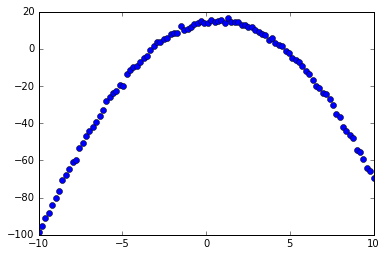

In [12]:
#Los datos
plt.plot(X, t, 'o')
plt.show()

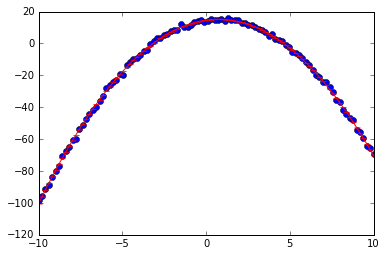

In [13]:
#Los datos y la regresión (en verde)
plt.plot(X, t, 'o')
y2, sigma_y2 = prediction(X, m_N, beta, S_N, M)
plt.errorbar(X, y2, yerr = sigma_y2, color=(1,0,0))
plt.show()